In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [45]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load NIH data
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(30)


Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
20886,00005573_001.png,Effusion|Infiltration,1,5573,8,M,PA,2048,2500,0.171000,0.171000,NaN,None
100807,00026777_001.png,No Finding,1,26777,43,M,AP,3056,2544,0.139000,0.139000,NaN,None
101616,00026995_000.png,No Finding,0,26995,45,M,PA,2992,2991,0.143000,0.143000,NaN,None
12913,00003388_004.png,No Finding,4,3388,49,M,PA,2500,2048,0.168000,0.168000,NaN,None
103107,00027474_002.png,Atelectasis,2,27474,13,F,AP,3056,2544,0.139000,0.139000,NaN,None
107511,00029039_021.png,Effusion|Pneumothorax,21,29039,61,M,AP,3056,2544,0.139000,0.139000,NaN,None
62128,00015376_009.png,No Finding,9,15376,60,F,AP,2500,2048,0.168000,0.168000,NaN,None
18034,00004833_016.png,No Finding,16,4833,27,M,AP,2500,2048,0.171000,0.171000,NaN,None
32490,00008490_003.png,Fibrosis|Infiltration,3,8490,58,M,PA,2992,2991,0.143000,0.143000,NaN,None
3790,00001034_001.png,No Finding,1,1034,72,M,AP,2500,2048,0.168000,0.168000,NaN,None


## EDA

### 1. Diseases distribution

Find the proportion of the images with pneumonia/without pneumonia.

In [46]:
all_xray_df = all_xray_df.rename(columns = {'Image Index' : 'image_index', 'Finding Labels': 'finding_labels',
                             'Follow-up #':'follow_up', 'Patient ID': 'patient_id', 'Patient Age':'patient_age',
                             'Patient Gender':'patient_gender', 'View Position':'view_position', 
                              'OriginalImage[Width':'orig_img_width', 'Height]':'orig_img_height',
                             'OriginalImagePixelSpacing[x':'pixel_spacing', 'Unnamed: 11':'unnamed_11'})

In [49]:
all_xray_df.loc[all_xray_df['finding_labels'].str.contains('Pneumonia')].shape[0]

1431

In [50]:
all_xray_df[all_xray_df['finding_labels'].str.contains('Pneumonia')].shape[0]/all_xray_df.shape[0]

0.012763110952550838

Only 1% of the total images have diagnosed pneumonia.
That means that we'll need to discard most of the images while training

Now, show the distribution of all 14 diseases 

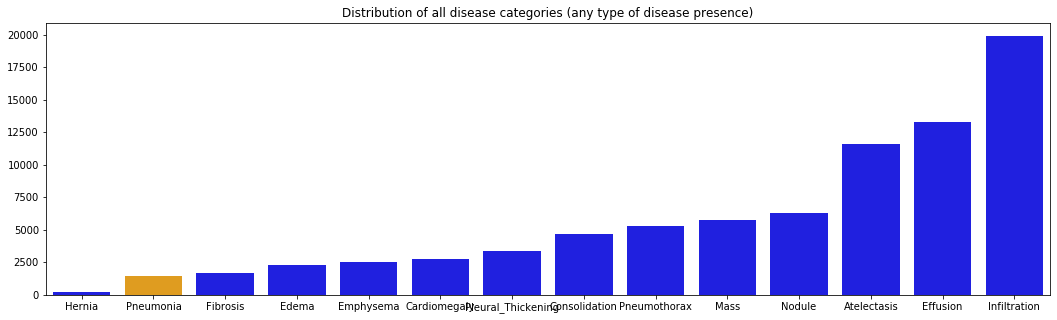

In [7]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['finding_labels'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of all disease categories (any type of disease presence)')
sns.barplot(diseases, diseases_counts, palette=pal);

Now, let's check the distribution for primary deseases

In [8]:
new = all_xray_df["finding_labels"].str.split('|', n=1, expand=True)
all_xray_df['disease'] = new[0]
all_xray_df['comorbidity'] = new[1]

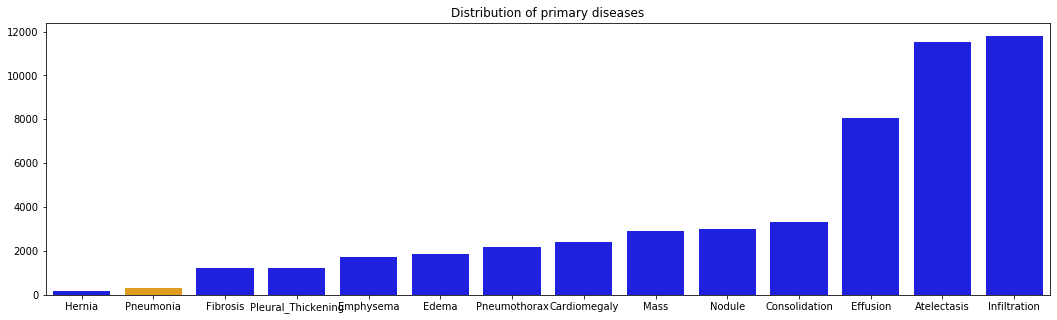

In [9]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['disease'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of primary diseases')
sns.barplot(diseases, diseases_counts, palette=pal);

In [10]:
all_xray_df.comorbidity.fillna(value='No Finding', inplace=True)

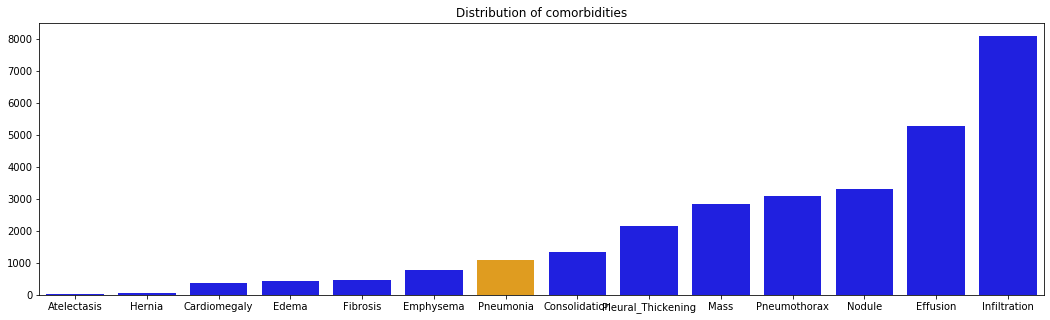

In [11]:
diseases = np.array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 
            'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
diseases_counts = []

for disease in diseases:
    diseases_counts.append(all_xray_df[all_xray_df['comorbidity'].str.contains(disease)].shape[0])
diseases_counts = np.array(diseases_counts)
diseases = diseases[diseases_counts.argsort()]
diseases_counts.sort()

pal = ['blue' if x != 'Pneumonia' else 'orange' for x in diseases]

plt.figure(figsize=(18,5))
plt.title('Distribution of comorbidities')
sns.barplot(diseases, diseases_counts, palette=pal);

As we can see from this plot, Pneumonia is mostly a comorbidity. So it will be important to check if there is a pneumonia as a comorbidity before discarding a sample while pre-processing the dataset for training.

### 2. Demographics

#### Age distribution

In [14]:
all_xray_df.patient_age.max()

414

In [21]:
all_xray_df.loc[all_xray_df['patient_age'] > 120, 'patient_age'] = all_xray_df[all_xray_df['patient_age'] > 120]['patient_age'].map(lambda x: x/10).max()

In [22]:
all_xray_df.patient_age.max()

95.0

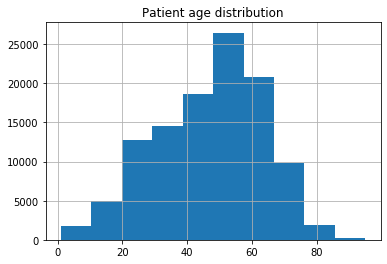

In [41]:
ax = all_xray_df.patient_age.hist()
ax.set_title('Patient age distribution');

Here we can see a normal distribution, it's already fine for further data processing 

#### Gender distribution

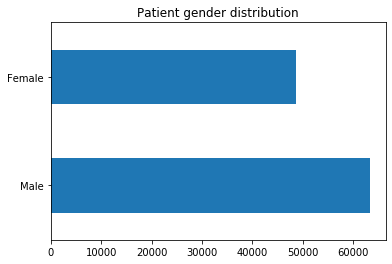

In [43]:
ax = all_xray_df.patient_gender.value_counts().plot(kind='barh')
ax.set_yticklabels(['Male', 'Female'])
ax.set_title('Patient gender distribution');

From this bar chart we can see that the difference in gender distribution is not crucial, but there are more x-rays taken from men. It will probably worth adding a bit of zooming in the data augmentation process.